##  Fossil-Classifier Transfer Learning resnet101v2

2025-08-03 07:47:54.826588: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754207274.860033     185 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754207274.875665     185 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1754207289.524606     185 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
Loaded RESNET101V2  ·  input (224, 224)
Found 44103 files belonging to 12 classes.
Cause: could not parse the source code of <function make_ds.<locals>.<lambda> at 0x7fc8a09afec0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function make_ds.<locals>.<lambda> at 0x7fc92c4c8900>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function make_ds.<locals>.<lambda> at 0x7fc92c087ec0>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Found 14046 files belonging to 12 classes.
Cause: could not parse the source code of <function make_ds.<locals>.<lambda> at 0x7fc92c181760>: no matching AST found a

I0000 00:00:1754207400.744984     215 service.cc:148] XLA service 0x7fc844003190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754207400.745612     215 service.cc:156]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
I0000 00:00:1754207410.196428     215 cuda_dnn.cc:529] Loaded cuDNN version 90700
I0000 00:00:1754207434.321674     215 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1379/1379 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - acc: 0.7229 - auc: 0.7786 - loss: 0.9865 - top3: 0.8942   
Epoch 1: val_acc improved from -inf to 0.77673, saving model to results_stronger_regularization_v11_segmented_o3/resnet101v2/ckpts/best.keras
1379/1379 ━━━━━━━━━━━━━━━━━━━━ 1030s 659ms/step - acc: 0.7229 - auc: 0.7786 - loss: 0.9864 - top3: 0.8943 - val_acc: 0.7767 - val_auc: 0.9847 - val_loss: 0.5756 - val_top3: 0.9648
Epoch 2/10
1379/1379 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - acc: 0.8550 - auc: 0.8133 - loss: 0.6852 - top3: 0.9682   
Epoch 2: val_acc improved from 0.77673 to 0.80678, saving model to results_stronger_regularization_v11_segmented_o3/resnet101v2/ckpts/best.keras
1379/1379 ━━━━━━━━━━━━━━━━━━━━ 845s 611ms/step - acc: 0.8550 - auc: 0.8133 - loss: 0.6852 - top3: 0.9682 - val_acc: 0.8068 - val_auc: 0.9876 - val_loss: 0.5110 - val_top3: 0.9770
Epoch 3/10
1379/1379 ━━━━━━━━━━━━━━━━━━━━ 0s 599ms/step - acc: 0.8763 - auc: 0.8240 - loss: 0.6341 - top3: 0.9752   
Epoch 3: val_a

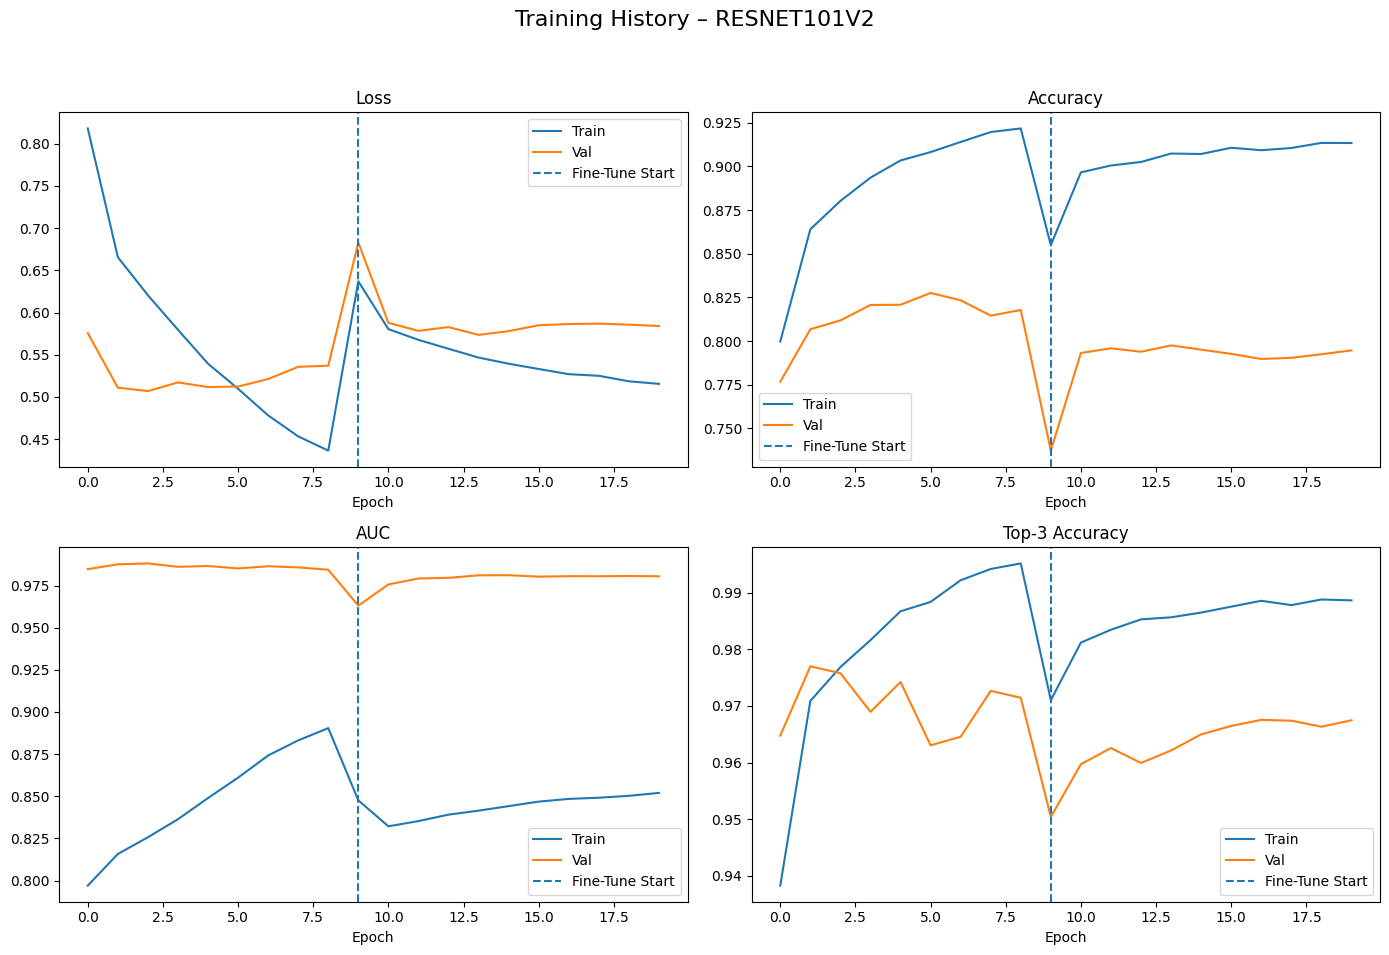

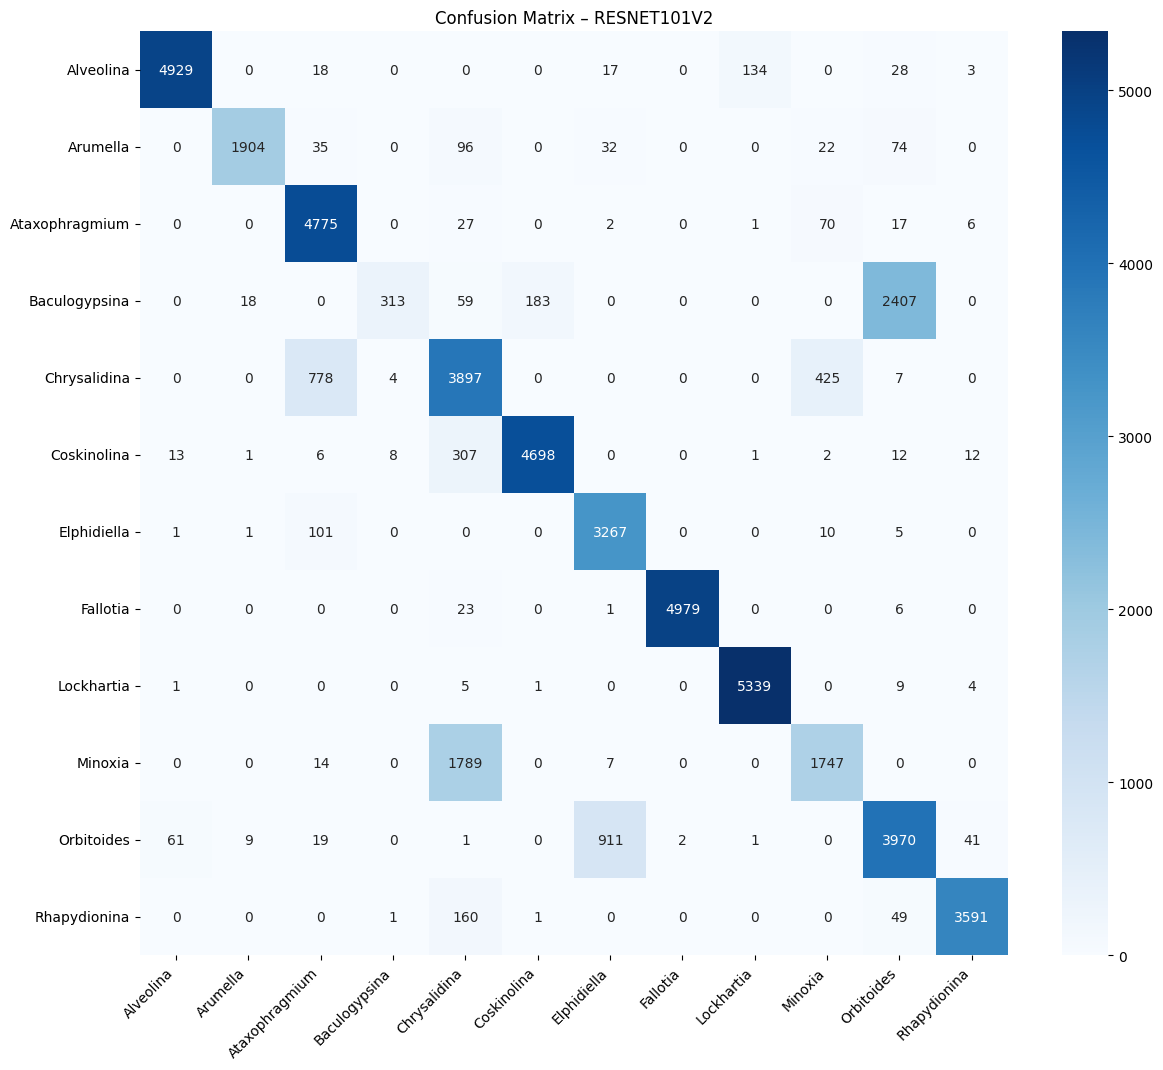


✅ All done - outputs saved in: results_stronger_regularization_v11_segmented_o3/resnet101v2
CPU times: user 7h 1min 54s, sys: 16min 39s, total: 7h 18min 33s
Wall time: 4h 31min 55s


In [ ]:
%%time
# ============================================================================ 
#  Fossil-Classifier  ·   (BBox Crop + MixUp/CutMix + Focal+LabelSmooth + EMA)
#  – Two-stage schedule (Freeze-10 ➜ Fine-Tune-20)   ·  EMA checkpoint
# ============================================================================

# ░░ 0 · Imports & reproducibility ░░
import os, warnings, random, json, math, datetime, pathlib, gc, numpy as np
import sys

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
from absl import logging as absl_logging; absl_logging.set_verbosity(absl_logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)

SEED = 42
random.seed(SEED); np.random.seed(SEED); os.environ["PYTHONHASHSEED"] = str(SEED)

import tensorflow as tf
tf.random.set_seed(SEED); tf.get_logger().setLevel("ERROR")
AUTOTUNE = tf.data.AUTOTUNE

def tf_beta_sample(alpha, shape, dtype=tf.float32):
    g1 = tf.random.gamma(shape, alpha, dtype=dtype)
    g2 = tf.random.gamma(shape, alpha, dtype=dtype)
    return g1 / (g1 + g2)

# Get the root directory of the project (Fossil_Project)
try:
    # Works in normal .py scripts
    PROJECT_ROOT = pathlib.Path(__file__).resolve().parent.parent
except NameError:
    # Fallback for Jupyter notebooks
    PROJECT_ROOT = pathlib.Path.cwd().parent

# ░░ 1 · User params ░░
DATA_ROOT = PROJECT_ROOT / "1_Dataset_Creation" / "3d_fossil_dataset_segmented_final"
SELECTED_MODEL         = "resnet101v2"          # pick any key from REGISTRY
BATCH_SIZE             = 32
FREEZE_EPOCHS          = 10
FINETUNE_EPOCHS        = 20

IMG_SIZE_SMALL         = (224,224)
IMG_SIZE_BIG           = (384,384)
UNFREEZE_MAP           = {
    "convnextl":120,"effv2l":80,"convnext":80,
    "effv2s":60,"nasnet":60,"resnet101v2":60,"mobilenet":999
}

# ░░ 2 · Output folders ░░
MODEL_DIR = PROJECT_ROOT / "3_Results" / SELECTED_MODEL
CKPT_DIR    = MODEL_DIR/"ckpts"
FIG_DIR     = MODEL_DIR/"figures"
REPORT_DIR  = MODEL_DIR/"reports"
for d in (CKPT_DIR, FIG_DIR, REPORT_DIR): d.mkdir(parents=True, exist_ok=True)

RUN_ID  = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
LOG_DIR = MODEL_DIR/"logs"/f"{SELECTED_MODEL}_{RUN_ID}"; LOG_DIR.mkdir(parents=True, exist_ok=True)

# ░░ 3 · Backbone registry ░░
def _convnext_large():
    from tensorflow.keras.applications import ConvNeXtLarge, convnext
    return ConvNeXtLarge(weights="imagenet", include_top=False,
                         input_shape=(*IMG_SIZE_BIG,3)), convnext.preprocess_input, IMG_SIZE_BIG

def _convnext():
    from tensorflow.keras.applications import ConvNeXtBase, convnext
    return ConvNeXtBase(weights="imagenet", include_top=False,
                        input_shape=(*IMG_SIZE_SMALL,3)), convnext.preprocess_input, IMG_SIZE_SMALL

def _effv2s():
    from tensorflow.keras.applications import EfficientNetV2S, efficientnet_v2
    return EfficientNetV2S(weights="imagenet", include_top=False,
                           input_shape=(*IMG_SIZE_SMALL,3)), efficientnet_v2.preprocess_input, IMG_SIZE_SMALL

def _effv2l():
    from tensorflow.keras.applications import EfficientNetV2L, efficientnet_v2
    return EfficientNetV2L(weights="imagenet", include_top=False,
                           input_shape=(*IMG_SIZE_BIG,3)),  efficientnet_v2.preprocess_input, IMG_SIZE_BIG

def _nasnet():
    from tensorflow.keras.applications import NASNetLarge, nasnet
    return NASNetLarge(weights="imagenet", include_top=False,
                       input_shape=(331,331,3)), nasnet.preprocess_input, (331,331)

def _resnet101v2():
    from tensorflow.keras.applications import ResNet101V2, resnet_v2
    return ResNet101V2(weights="imagenet", include_top=False,
                       input_shape=(*IMG_SIZE_SMALL,3)), resnet_v2.preprocess_input, IMG_SIZE_SMALL

def _mobilenet():
    from tensorflow.keras.applications import MobileNet, mobilenet
    return MobileNet(weights="imagenet", include_top=False,
                     input_shape=(*IMG_SIZE_SMALL,3)), mobilenet.preprocess_input, IMG_SIZE_SMALL

REGISTRY = {
    "convnextl":_convnext_large,
    "convnext":_convnext,
    "effv2s":_effv2s,
    "effv2l":_effv2l,
    "nasnet":_nasnet,
    "resnet101v2":_resnet101v2,
    "mobilenet":_mobilenet
}

backbone, prep_fn, IMG_SIZE = REGISTRY[SELECTED_MODEL]()
print(f"Loaded {SELECTED_MODEL.upper()}  ·  input {IMG_SIZE}")

# ░░ 4 · Bounding-box crop helper (dtype-safe) ░░
@tf.autograph.experimental.do_not_convert
def crop_to_bbox(img):
    gray   = tf.image.rgb_to_grayscale(img)
    mask   = tf.where(gray > 0.05, 1, 0)
    coords = tf.cast(tf.where(tf.squeeze(mask)), tf.int32)

    y_min = tf.reduce_min(coords[:, 0]) - 5
    y_max = tf.reduce_max(coords[:, 0]) + 5
    x_min = tf.reduce_min(coords[:, 1]) - 5
    x_max = tf.reduce_max(coords[:, 1]) + 5

    h = tf.shape(img, out_type=tf.int32)[0]
    w = tf.shape(img, out_type=tf.int32)[1]

    y_min = tf.clip_by_value(y_min, 0, h)
    x_min = tf.clip_by_value(x_min, 0, w)
    y_max = tf.clip_by_value(y_max, 0, h)
    x_max = tf.clip_by_value(x_max, 0, w)

    crop = img[y_min:y_max, x_min:x_max]
    return tf.image.resize_with_pad(crop, *IMG_SIZE)

# ░░ 5 · Dataset with MixUp / CutMix ░░
@tf.autograph.experimental.do_not_convert
def _mixup_cutmix(images, labels, alpha=0.2, cutmix_prob=0.5):
    batch_sz = tf.shape(images)[0]
    lam = tf_beta_sample(alpha, [batch_sz, 1, 1, 1])           # [B,1,1,1]
    lam_flat = tf.reshape(lam, [batch_sz])                    # [B]
    idx = tf.random.shuffle(tf.range(batch_sz))
    img2, lab2 = tf.gather(images, idx), tf.gather(labels, idx)

    def do_cutmix():
        rx = tf.random.uniform([batch_sz], 0, IMG_SIZE[1], dtype=tf.float32)
        ry = tf.random.uniform([batch_sz], 0, IMG_SIZE[0], dtype=tf.float32)

        rw = IMG_SIZE[1] * tf.sqrt(1.0 - lam_flat)
        rh = IMG_SIZE[0] * tf.sqrt(1.0 - lam_flat)

        rw_int = tf.cast(rw, tf.int32)
        rh_int = tf.cast(rh, tf.int32)

        x1 = tf.cast(tf.clip_by_value(rx - 0.5 * tf.cast(rw_int, tf.float32), 0.0, float(IMG_SIZE[1])), tf.int32)
        y1 = tf.cast(tf.clip_by_value(ry - 0.5 * tf.cast(rh_int, tf.float32), 0.0, float(IMG_SIZE[0])), tf.int32)
        x2 = tf.clip_by_value(x1 + rw_int, 0, IMG_SIZE[1])
        y2 = tf.clip_by_value(y1 + rh_int, 0, IMG_SIZE[0])

        def make_mask(i):
            y1_i, y2_i = y1[i], y2[i]
            x1_i, x2_i = x1[i], x2[i]
            mask = tf.pad(
                tf.ones((y2_i - y1_i, x2_i - x1_i, 3), dtype=images.dtype),
                [[y1_i, IMG_SIZE[0] - y2_i], [x1_i, IMG_SIZE[1] - x2_i], [0, 0]]
            )
            return mask

        masks = tf.map_fn(make_mask, tf.range(batch_sz), dtype=images.dtype)  # [B,H,W,3]
        images_cut = images * (1 - masks) + img2 * masks

        area = tf.cast((x2 - x1) * (y2 - y1), tf.float32)  # [B]
        lam_scalar = 1.0 - area / (IMG_SIZE[0] * IMG_SIZE[1])  # [B]
        lam_scalar = tf.reshape(lam_scalar, [batch_sz, 1])  # [B,1]

        labels_cut = lam_scalar * labels + (1 - lam_scalar) * lab2
        return images_cut, labels_cut

    def do_mixup():
        images_mix = lam * images + (1 - lam) * img2
        lam_lbl = tf.reshape(lam_flat, [batch_sz, 1])
        labels_mix = lam_lbl * labels + (1 - lam_lbl) * lab2
        return images_mix, labels_mix

    rnd = tf.random.uniform([], 0.0, 1.0)
    images_out, labels_out = tf.cond(rnd < cutmix_prob, do_cutmix, do_mixup)
    return images_out, labels_out

def make_ds(split):
    base = tf.keras.utils.image_dataset_from_directory(
        DATA_ROOT/f"{split}", image_size=IMG_SIZE, batch_size=BATCH_SIZE,
        shuffle=(split=="train_split"), seed=SEED, label_mode="categorical")
    class_names = base.class_names

    ds = base
    ds = ds.map(lambda x,y: (tf.map_fn(crop_to_bbox, x), y), num_parallel_calls=AUTOTUNE)
    if split=="train_split":
        aug = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=SEED),
            tf.keras.layers.RandomRotation(0.3, seed=SEED),
            tf.keras.layers.RandomContrast(0.3, seed=SEED),
            tf.keras.layers.RandomZoom(0.25, seed=SEED)])
        ds = ds.map(lambda x,y: (aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
        ds = ds.map(lambda x,y: (prep_fn(x), y), num_parallel_calls=AUTOTUNE)
        ds = ds.map(_mixup_cutmix, num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x,y: (prep_fn(x), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(AUTOTUNE), class_names

train_ds, CLASS_NAMES = make_ds("train_split")
val_ds, _ = make_ds("val_split")
test_ds, _ = make_ds("test")
NUM_CLASSES = len(CLASS_NAMES)
(REPORT_DIR/f"class_map_{SELECTED_MODEL}.json").write_text(
    json.dumps({i:c for i,c in enumerate(CLASS_NAMES)}))

# ░░ 6 · Model head ░░
inputs = tf.keras.Input(shape=(*IMG_SIZE,3))
x = backbone(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", dtype="float32")(x)
model = tf.keras.Model(inputs, outputs)

# ░░ 7 · Loss & metrics ░░
def focal_loss_with_label_smoothing(gamma=1.5, epsilon=0.05):
    def loss(y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_true)[-1], tf.float32)
        y_true_sm = y_true * (1.0 - epsilon) + epsilon / num_classes
        y_pred_clipped = tf.clip_by_value(y_pred, 1e-7, 1.0)
        ce = - y_true_sm * tf.math.log(y_pred_clipped)  # [B, C]
        weight = tf.pow(1.0 - y_pred_clipped, gamma)    # [B, C]
        loss_tensor = weight * ce                       # [B, C]
        return tf.reduce_sum(loss_tensor, axis=-1)      # per-example
    return loss

loss_fn  = focal_loss_with_label_smoothing(gamma=1.5, epsilon=0.05)
metrics  = [
    tf.keras.metrics.CategoricalAccuracy(name="acc"),
    tf.keras.metrics.TopKCategoricalAccuracy(k=3, name="top3"),
    tf.keras.metrics.AUC(name="auc")
]

# ░░ EMA callback (replacement for StructuredEMA) ░░
class SimpleEMA(tf.keras.callbacks.Callback):
    def __init__(self, momentum=0.999):
        super().__init__()
        self.momentum = momentum
        self.ema_weights = None
        self.backup_weights = None
        self._model = None

    def set_model(self, model):
        self._model = model
        self.ema_weights = [tf.identity(w) for w in self._model.get_weights()]

    def on_batch_end(self, batch, logs=None):
        current = self._model.get_weights()
        self.ema_weights = [
            self.momentum * ew + (1.0 - self.momentum) * cw
            for ew, cw in zip(self.ema_weights, current)
        ]

    def on_test_begin(self, logs=None):
        if self._model is None:
            return
        self.backup_weights = self._model.get_weights()
        self._model.set_weights(self.ema_weights)

    def on_test_end(self, logs=None):
        if self._model is None or self.backup_weights is None:
            return
        self._model.set_weights(self.backup_weights)
        self.backup_weights = None

# ░░ 8 · Stage-1 (frozen) ░░
train_card = tf.data.experimental.cardinality(train_ds).numpy()
lr1 = tf.keras.optimizers.schedules.CosineDecay(3e-4, train_card * FREEZE_EPOCHS)
opt1 = tf.keras.optimizers.AdamW(lr1, weight_decay=5e-4)
model.compile(optimizer=opt1, loss=loss_fn, metrics=metrics)

tb_cb   = tf.keras.callbacks.TensorBoard(log_dir=str(LOG_DIR))
ema_cb  = SimpleEMA(momentum=0.999)
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    CKPT_DIR/"best.keras", monitor="val_acc", save_best_only=True, verbose=1)
es_cb   = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=6, restore_best_weights=True, verbose=1)

print("\n—— Stage 1 (Frozen) ——")
hist1 = model.fit(
    train_ds, validation_data=val_ds, epochs=FREEZE_EPOCHS,
    callbacks=[tb_cb, ckpt_cb, es_cb, ema_cb]
)

# ░░ 9 · Stage-2 (top-N) ░░
backbone.trainable = True
N = UNFREEZE_MAP[SELECTED_MODEL]
for lyr in backbone.layers[:-N]:
    lyr.trainable = False

opt2 = tf.keras.optimizers.AdamW(1e-5, weight_decay=5e-4, clipnorm=1.0)
model.compile(optimizer=opt2, loss=loss_fn, metrics=metrics)

print("\n—— Stage 2 (Fine-Tune top-N) ——")
hist2 = model.fit(
    train_ds, validation_data=val_ds,
    epochs=FREEZE_EPOCHS + FINETUNE_EPOCHS, initial_epoch=FREEZE_EPOCHS,
    callbacks=[tb_cb, ckpt_cb, es_cb, ema_cb]
)

# ░░ 10 · Evaluation ░░
# load best checkpoint (non-EMA) for consistency, then evaluate with EMA weights separately
model = tf.keras.models.load_model(CKPT_DIR/"best.keras", compile=False)
model.compile(loss=loss_fn, metrics=metrics)
results = dict(zip(model.metrics_names, model.evaluate(test_ds, verbose=0)))
for k,v in results.items(): print(f"{k:>9s} : {v:.4f}")

# save standard best model
model.save(MODEL_DIR/f"fossil_{SELECTED_MODEL}.keras")

# save EMA-weighted model
# apply EMA weights from callback (if available)
if ema_cb.ema_weights is not None:
    original = model.get_weights()
    model.set_weights(ema_cb.ema_weights)
    model.save(MODEL_DIR/f"fossil_{SELECTED_MODEL}_ema.keras")
    model.set_weights(original)

# ░░ 11 · History merge & save ░░
def _merge(histories, key):
    out=[]
    for h in histories: out += h.history.get(key,[])
    return out

all_hist = {
    "loss":_merge([hist1,hist2],"loss"),
    "val_loss":_merge([hist1,hist2],"val_loss"),
    "acc":_merge([hist1,hist2],"acc"),
    "val_acc":_merge([hist1,hist2],"val_acc"),
    "auc":_merge([hist1,hist2],"auc"),
    "val_auc":_merge([hist1,hist2],"val_auc"),
    "top3":_merge([hist1,hist2],"top3"),
    "val_top3":_merge([hist1,hist2],"val_top3")
}
(REPORT_DIR/f"training_history_{SELECTED_MODEL}.json").write_text(json.dumps(all_hist, indent=4))

# ░░ 12 · Plots ░░
import matplotlib.pyplot as plt, seaborn as sns
plt.figure(figsize=(14,10)); plt.suptitle(f"Training History – {SELECTED_MODEL.upper()}", fontsize=16)
for i,(k,title) in enumerate([("loss","Loss"),("acc","Accuracy"),("auc","AUC"),("top3","Top-3 Accuracy")]):
    plt.subplot(2,2,i+1)
    plt.plot(all_hist[k], label="Train"); plt.plot(all_hist[f"val_{k}"], label="Val")
    plt.axvline(FREEZE_EPOCHS-1, linestyle="--", label="Fine-Tune Start")
    plt.title(title); plt.xlabel("Epoch"); plt.legend()
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.savefig(FIG_DIR/f"history_{SELECTED_MODEL}.pdf", bbox_inches='tight')

# ░░ 13 · Classification report & confusion matrix ░░
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
probs  = model.predict(test_ds, verbose=0); y_pred = probs.argmax(1)
y_true_one_hot = np.concatenate([y for _,y in test_ds]); y_true = y_true_one_hot.argmax(1)
test_acc = accuracy_score(y_true,y_pred)
top3 = tf.keras.metrics.top_k_categorical_accuracy(y_true_one_hot, probs, k=3).numpy().mean()
auc  = roc_auc_score(y_true_one_hot, probs, multi_class="ovr")
macro_f1 = f1_score(y_true,y_pred,average="macro")
header = f"""
Overall Test Metrics
====================
Test Accuracy : {test_acc:.4f}
Top-3 Accuracy: {top3:.4f}
Test AUC      : {auc:.4f}
Macro-F1      : {macro_f1:.4f}

Classification Report
====================
"""
full_rep = header + classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4)
(REPORT_DIR/f"classification_report_{SELECTED_MODEL}.txt").write_text(full_rep)
print(full_rep)

cm = confusion_matrix(y_true,y_pred)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.title(f"Confusion Matrix – {SELECTED_MODEL.upper()}")
plt.savefig(FIG_DIR/f"cm_{SELECTED_MODEL}.pdf", dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ All done - outputs saved in:", MODEL_DIR)
